In [153]:
# Import relevant packages 
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [154]:
ohe = OneHotEncoder(sparse=False)
scaler = StandardScaler()
pca = PCA()

In [155]:
df = pd.read_csv('data/twm_customer.csv',sep=';')

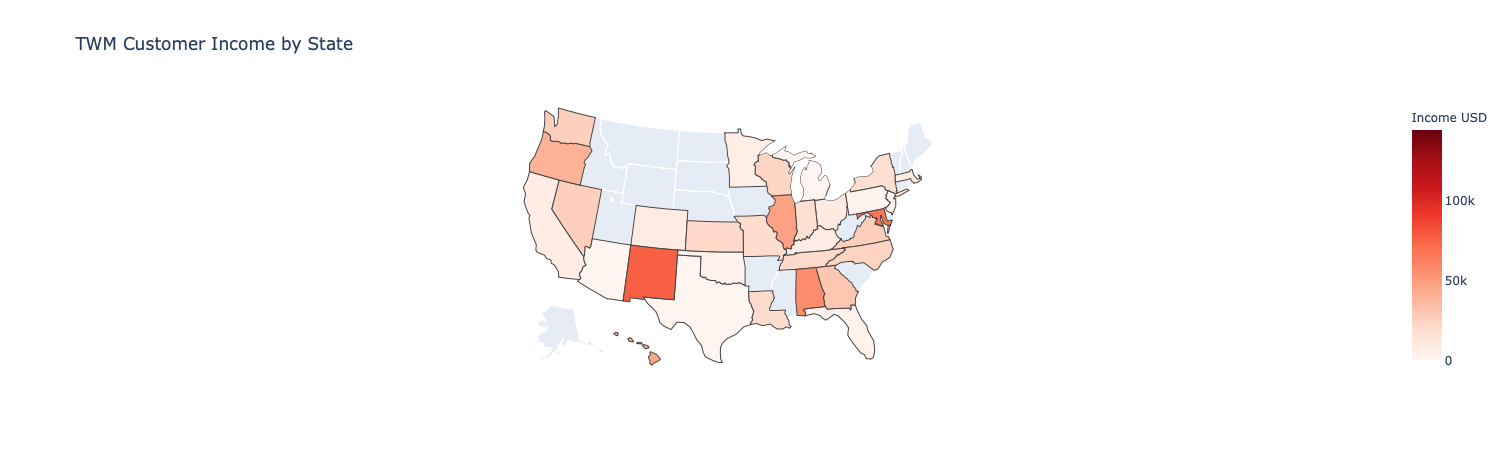

In [156]:
state_list = ['NV', 'CA', 'NY', 'IL', 'HI', 'DC', 'TX', 'PA', 'OR', 'OH', 'WA', 'NJ', 'IN', 'CO', 'WI', 'MI', 'NB', 'AZ', 'MN', 'TN', 'VA', 'FL', 'MD', 'MO', 'LA', 'KY', 'OK', 'MA',
'GA', 'KS', 'NC', 'NM', 'AL']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = df['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'TWM Customer Income by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [157]:
state_labels = {st : i for i, st in enumerate(df.state_code.unique())} # dictionary comprehension for statecode re-labeling
df= df.replace({'gender': {'M ': 0, 'F ': 1},'state_code': state_labels }) # replace gender strings with binary values, replace state code with labels
marital_status_df = pd.DataFrame(ohe.fit_transform(df[['marital_status']]),  dtype='int64') # one hot encode values for marital status
df = df.drop(columns=['cust_id','first_name','last_name','name_prefix','street_nbr','street_name','postal_code','city_name','marital_status']) # drop unnecessary columns

In [158]:
df = pd.concat([df, marital_status_df], axis=1)

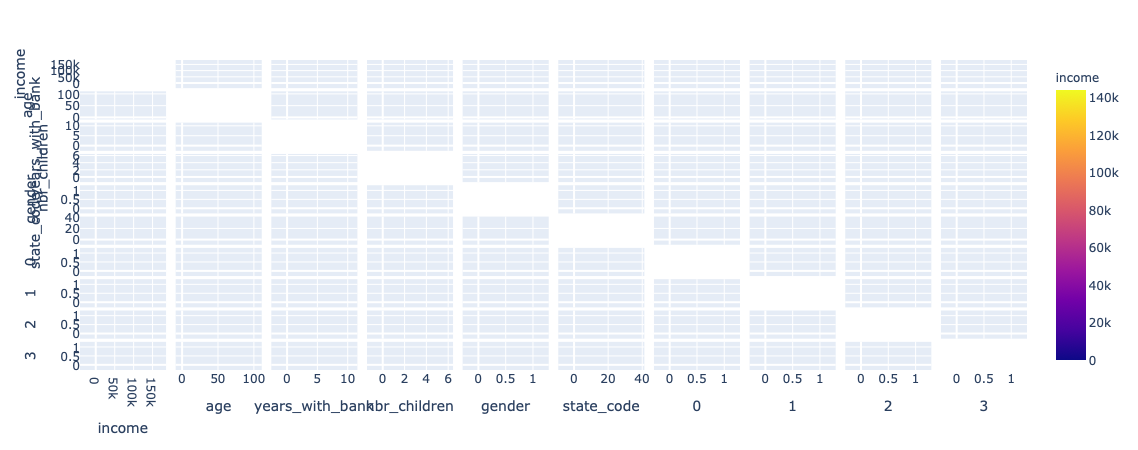

In [159]:
features = list(df.columns)

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="income"
)
fig.update_traces(diagonal_visible=False)
fig.show()

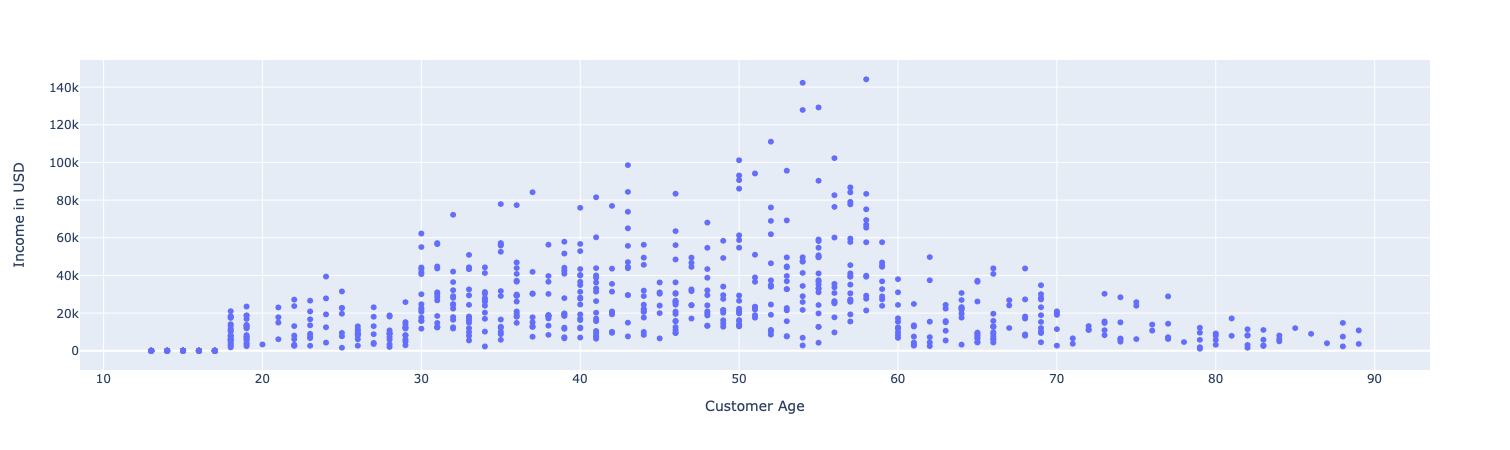

In [160]:
fig = px.scatter(df, x='age',y='income',labels={'income':'Income in USD', 'age': 'Customer Age'})
fig.show()

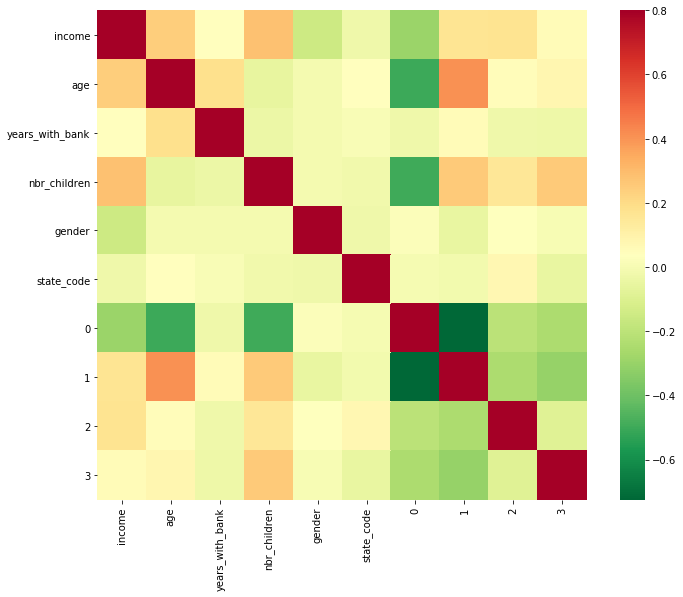

In [161]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r")

In [162]:
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df

,income,age,years_with_bank,nbr_children,gender,state_code,0,1,2,3
0,0.154185,0.184312,0.408539,0.258591,-1.127172,-0.982716,-0.765498,1.056479,-0.262049,-0.321555
1,-0.726524,1.493070,-1.087435,-0.648298,-1.127172,-0.867020,-0.765498,1.056479,-0.262049,-0.321555
2,-0.188366,-0.234490,1.530520,-0.648298,0.887176,-0.867020,1.306339,-0.946541,-0.262049,-0.321555
3,1.123798,0.603115,-0.339448,-0.648298,0.887176,-0.867020,1.306339,-0.946541,-0.262049,-0.321555
4,0.983479,0.864867,1.904514,1.165479,0.887176,-0.751325,-0.765498,-0.946541,-0.262049,3.109892
...,...,...,...,...,...,...,...,...,...,...
742,-0.357478,-0.339191,0.782533,0.258591,0.887176,-0.867020,-0.765498,-0.946541,-0.262049,3.109892
743,0.164864,0.707816,0.782533,0.258591,-1.127172,-0.751325,-0.765498,1.056479,-0.262049,-0.321555
744,1.738064,0.393714,-1.461429,1.165479,-1.127172,2.603849,-0.765498,1.056479,-0.262049,-0.321555
745,-0.343735,-0.286841,1.156526,-0.648298,0.887176,2.719545,-0.765498,1.056479,-0.262049,-0.321555


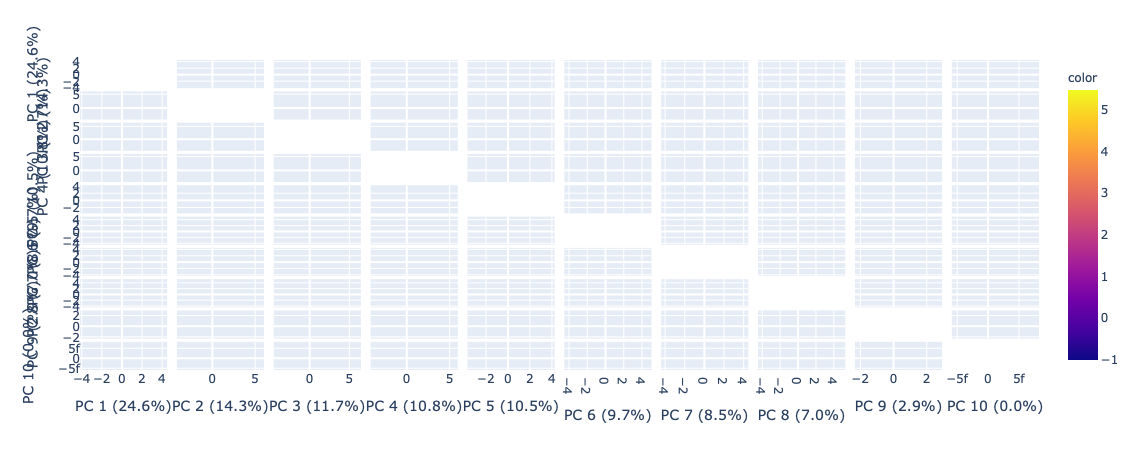

In [163]:
all_principal_components = pca.fit_transform(scaled_df)
labels = { str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
fig = px.scatter_matrix(
    all_principal_components, labels=labels, dimensions=range(10), color=scaled_df['income'])
fig.update_traces(diagonal_visible=False)
fig.show()

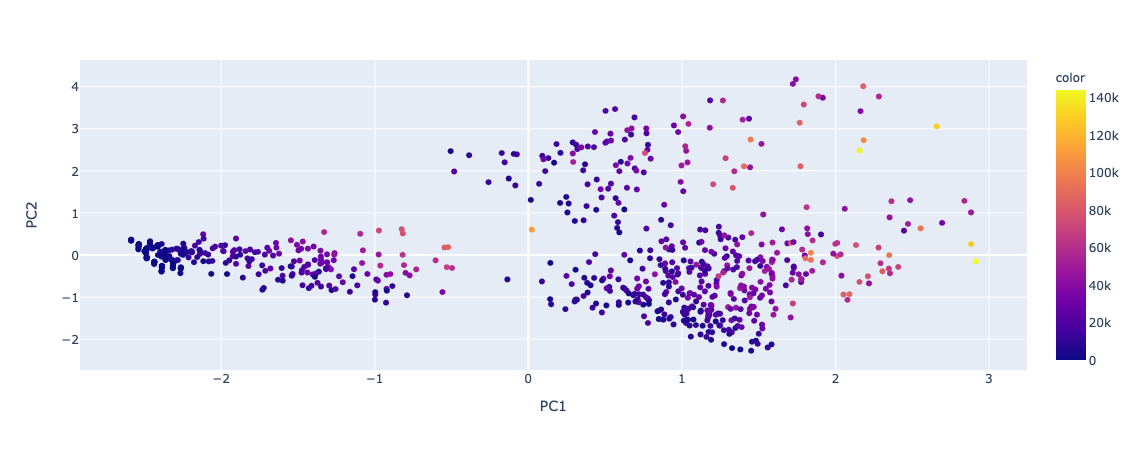

In [164]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)
labels = {
    'x':'PC1', 'y':'PC2'
}
fig = px.scatter(
    x = components[:, 0],
    y = components[:, 1],
    color=df['income'],
    labels=labels
)
# fig.update_traces(diagonal_visible=False)
fig.show()

In [165]:
# elbow rule
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

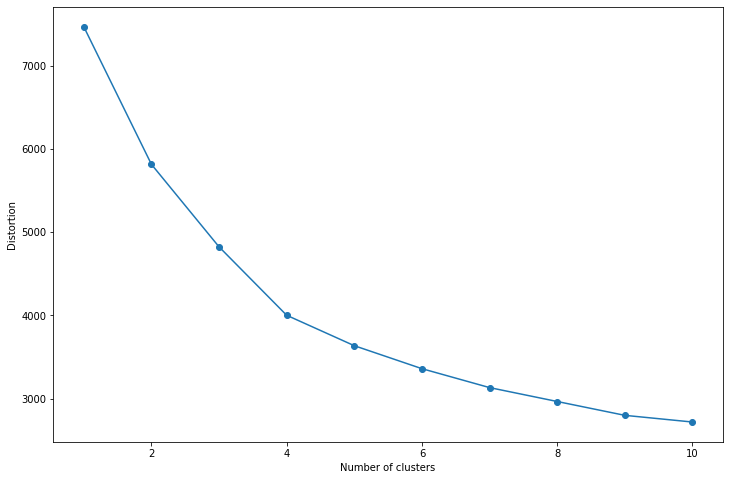

In [166]:
plot_distortion(scaled_df)

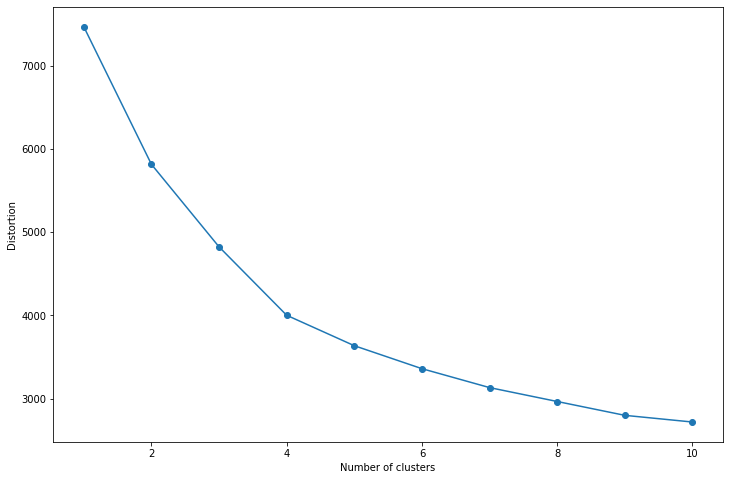

In [167]:
plot_distortion(all_principal_components)

In [168]:
km = KMeans(n_clusters=3 , n_init=10)
y_res = km.fit_predict(all_principal_components)

In [169]:
plt.rcParams["figure.figsize"] = (12,8)

In [170]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))
        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')
    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

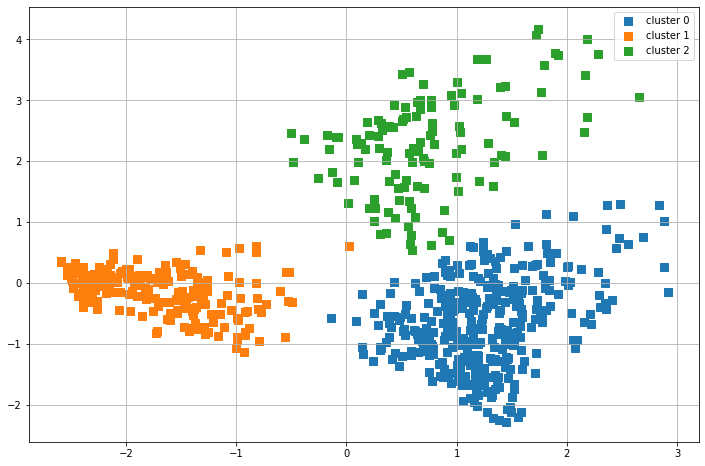

In [172]:
plot_clusters(all_principal_components,y_res)

In [173]:
feature_list = ['income','age','years_with_bank','nbr_children']

In [174]:
df['cluster_category'] = y_res

In [226]:
toplot_df = df
toplot_df['income'] = df['income'] / 1000

In [187]:
df_cluster1 = df[df['cluster_category'] == 0]
df_cluster2 = df[df['cluster_category'] == 1]
df_cluster3 = df[df['cluster_category'] == 2]

cluster_1_means = []
cluster_2_means = []
cluster_3_means = []

for feature in feature_list:
    cluster_1_means.append(df_cluster1[f'{feature}'].mean())
    cluster_2_means.append(df_cluster2[f'{feature}'].mean())
    cluster_3_means.append(df_cluster3[f'{feature}'].mean())
print('cluster1:',cluster_1_means)
print('cluster2:',cluster_2_means)
print('cluster3:',cluster_3_means)

cluster1: [26.587439093484424, 50.79603399433428, 4.065155807365439, 1.0141643059490084]
cluster2: [14.167228260869564, 29.92753623188406, 3.8115942028985508, 0.0]
cluster3: [31.207669491525408, 46.95762711864407, 3.6610169491525424, 1.4915254237288136]


In [225]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

### Plotting Averages for Cluster 1

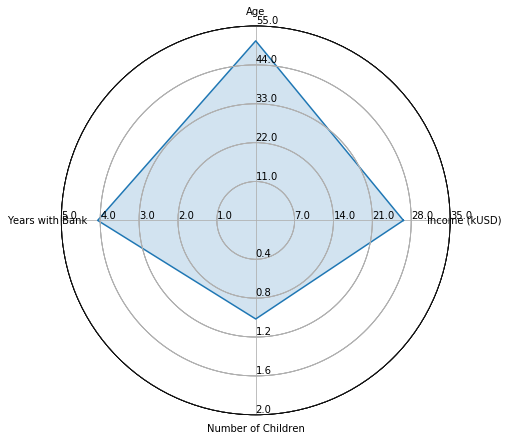

In [227]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (26.587439093484424, 50.79603399433428, 4.065155807365439, 1.0141643059490084)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    

### Plotting Averages for Cluster 2

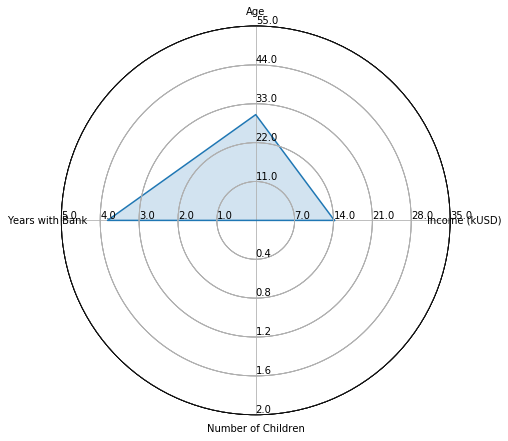

In [222]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (14.167228260869564, 29.92753623188406, 3.8115942028985508, 0.0)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    

### Plotting Averages for Cluster 3

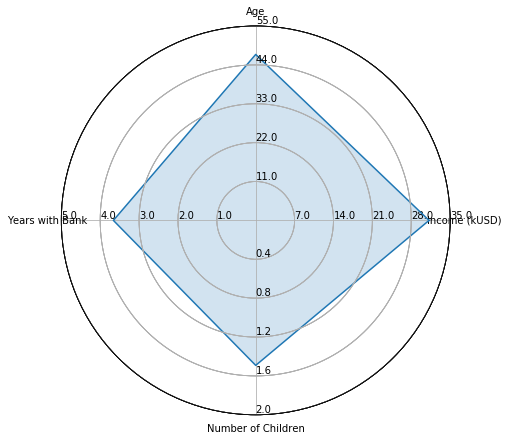

In [223]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (31.207669491525408, 46.95762711864407, 3.6610169491525424, 1.4915254237288136)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    